# Data Scraping HTML Probe
import requests
from bs4 import BeautifulSoup

def scrape_news(ticker):
    url = f'https://finviz.com/quote.ashx?t={ticker}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Print the content to inspect the structure
    print(soup.prettify())

# Remove comment tag and run cell to probe for crawler blockers.
#scrape_news('NVDA')
# Probe reveals a crawler blocker: <meta content="noindex,nofollow" name="robots"/>

# Data Scraping - Web Scraping

import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
from dateutil import parser

# The ticker is the stock market abbreviation for a company. The ticker for Nvidia is NVDA.
def scrape_news(ticker):
    url = f'https://finviz.com/quote.ashx?t={ticker}'
    # Request website as a user on a browser to bypass crawler blocker.
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Locate the news table
    news_table = soup.find('table', class_='fullview-news-outer')

    if news_table is None:
        raise ValueError("Could not find the news table")
    
    #print(news_table)

    parsed_news = []

    for row in news_table.findAll('tr'):
        title_tag = row.find('a')
        date_tag = row.find('td')
        
        if title_tag is None or date_tag is None:
            print(f"Skipping a row due to missing elements: {row}")
            continue

        title = title_tag.get_text().strip()
        date_data = date_tag.text.strip().split(' ')

        if len(date_data) == 1:
            date = datetime.now().strftime('%Y-%m-%d')  # Default to today's date if no date found
            time = date_data[0]
        else:
            if date_data[0] == 'Today':
                date = datetime.now().strftime('%Y-%m-%d')
            elif date_data[0] == 'Yesterday':
                date = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')
            else:
                try:
                    date = parser.parse(date_data[0]).strftime('%Y-%m-%d')
                except ValueError:
                    continue
            time = date_data[1]
        parsed_news.append([ticker, date, time, title])

    return pd.DataFrame(parsed_news, columns=['ticker', 'date', 'time', 'title'])

# Scrape the news for the ticker.
news_df = scrape_news('NVDA')

# Print the number of articles for that ticker.
print(f"Number of news articles scraped: {len(news_df)}")

# Print the first five rows to check formatting.
print(news_df.head())


In [178]:
# Above is for scraping a finviz data set. I will merge the data frames in the future. Below is where the project starts.

In [179]:
# Data Scraping - API Key
import requests
import pandas as pd

# The ticker is the stock market abbreviation for a company. The ticker for Apple is AAPL.
def fetch_news(api_key, ticker, from_date, to_date, page_size=100):
    url = 'https://newsapi.org/v2/everything'
    query = f'"{ticker}"'
    params = {
        'q': query,
        'from': from_date,
        'to': to_date,
        'sortBy': 'relevancy',
        'language': 'en',
        'apiKey': api_key,
        'pageSize': page_size
    }

    all_articles = []
    page = 1
    while True:
        params['page'] = page
        response = requests.get(url, params=params)
        data = response.json()

        # Print any error messages.
        if response.status_code != 200:
            print(f"Error fetching data: {data}")
            break

        articles = data.get('articles', [])
        if not articles:
            break

        all_articles.extend(articles)
        page += 1

    news_data = []
    for article in all_articles:
        date = article['publishedAt'][:10]
        content = article['content']
        news_data.append([ticker, date, content])

    return pd.DataFrame(news_data, columns=['ticker', 'date', 'content'])

api_key = 'newsapi_key'
from_date = '2024-08-11'
to_date = '2024-09-10'

# 14 stocks that the model predicted with under 3% MAPE each: AAPL, CRWD, PLTR, DELL, BA, LMT, NOC, PFE, BAC, JPM, MS, GS, VOO, QQQ, and more to test.
# For best results, either enter one stock of any category, or enter multiple stocks of one category. This decreases the variance of sentiment.
# Example: 'AAPL' (one technology stock) or 'AAPL', 'PLTR', 'DELL' (three technology stocks).
# Enter at least one stock ticker here.
ticker_array =['DELL']

articles_scraped = 0
news_array = []

# Scrape the news for the ticker.
for i in range(len(ticker_array)):
    news_array.append(fetch_news(api_key, ticker_array[i], from_date, to_date))
    articles_scraped += len(news_array[i])
    print(news_array[i].head(2))

print(f"Number of news articles scraped: {articles_scraped}")


Error fetching data: {'status': 'error', 'code': 'maximumResultsReached', 'message': 'You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results.'}
  ticker        date                                            content
0   DELL  2024-08-27  If you click 'Accept all', we and our partners...
1   DELL  2024-09-03  If you click 'Accept all', we and our partners...
Number of news articles scraped: 100


In [180]:
# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

def analyze_sentiment(df):
    sia = SentimentIntensityAnalyzer()
    df['sentiment'] = df['content'].apply(lambda x: sia.polarity_scores(x)['compound'])
    return df

# Perform sentiment analysis
for i in range(len(news_array)):
    analyze_sentiment(news_array[i])

    # Print the first five rows to check sentiment data. 
    # -1 implies negative sentiment toward the ticker, 1 implies positive sentiment toward the ticker.  
    print(news_array[i].head(2))


  ticker        date                                            content  \
0   DELL  2024-08-27  If you click 'Accept all', we and our partners...   
1   DELL  2024-09-03  If you click 'Accept all', we and our partners...   

   sentiment  
0     0.5423  
1     0.5423  


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ethantang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [181]:
# Scrape historical prices for the tickers
import yfinance as yf

def get_historical_prices(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

prices_array = []

for i in range(len(news_array)):
    prices_array.append(get_historical_prices(ticker_array[i], from_date, to_date))
    print(prices_array[i].head(2))


[*********************100%%**********************]  1 of 1 completed

                 Open        High        Low      Close  Adj Close    Volume
Date                                                                        
2024-08-12  92.199997   97.900002  91.839996  95.269997  95.269997   9875300
2024-08-13  97.099998  101.489998  96.570000  99.940002  99.940002  14928400


In [182]:
# Merge the Data Frames and Concatenate

# Ensure the date column is in datetime format for both news dataframes
for i in range(len(news_array)):
    news_array[i]['date'] = pd.to_datetime(news_array[i]['date'], format='%Y-%m-%d')

# Merge each news data frame with its corresponding historical prices data frame
merged_array = []
for i in range(len(news_array)):
    merged_array.append(pd.merge(news_array[i], prices_array[i], left_on='date', right_on='Date', how='inner'))

# Combine the merged data frames
final_merged_df = merged_array[0]
for i in range(len(news_array)-1):
    final_merged_df = pd.concat([merged_array[i], merged_array[i+1]]).reset_index(drop=True)

# Check the final merged DataFrame
print(final_merged_df.head(100))


   ticker       date                                            content  \
0    DELL 2024-08-27  If you click 'Accept all', we and our partners...   
1    DELL 2024-08-27  A look at the day ahead in U.S. and global mar...   
2    DELL 2024-08-27  The New York Times has plenty of word games on...   
3    DELL 2024-08-27  IntroductionI have mentioned in most of my rec...   
4    DELL 2024-08-27  As part of the Dell Labor Day Sale, Dell is cu...   
..    ...        ...                                                ...   
76   DELL 2024-08-23  Jalen Hurts is one of the highest-rated quarte...   
77   DELL 2024-08-23  Dude you’re getting a Dell. A very tiny Dell. ...   
78   DELL 2024-08-12  Skip to contentType your search and hit enter\...   
79   DELL 2024-08-12  Texans WR Stefon DiggsTim Warner/Getty Images\...   
80   DELL 2024-08-22  Skip to contentType your search and hit enter\...   

    sentiment        Open        High         Low       Close   Adj Close  \
0      0.5423  110.330

In [183]:
# Prepare Features and Labels
import torch

# Sort by date
final_merged_df.sort_values(by='date')

# Create features (sentiment) and labels (next day's closing price)
X = torch.tensor(final_merged_df['sentiment'].values, dtype=torch.float32).reshape(-1, 1)
y = torch.tensor(final_merged_df['Close'].shift(-1).dropna().values, dtype=torch.float32).reshape(-1, 1)

# Ensure X and y are of the same length after shifting
X = X[:-1]

# Verify shapes
print(X.shape, y.shape)


torch.Size([80, 1]) torch.Size([80, 1])


In [184]:
# Split the Data into Training Set and Testing Set
from sklearn.model_selection import train_test_split

# Assuming merged_df is your final DataFrame with features and target variable
# Replace 'Close' with your target variable column
X = final_merged_df[['sentiment']].values  # Add more features if available
y = final_merged_df['Close'].values  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


In [185]:
# Model Training
import torch.nn as nn
import torch.optim as optim

# Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training Loop
for epoch in range(4000):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Final loss after training
print(f'Final Training Loss: {loss.item()}')


Epoch 0, Loss: 11938.9921875
Epoch 10, Loss: 9237.845703125
Epoch 20, Loss: 6657.03662109375
Epoch 30, Loss: 3986.627197265625
Epoch 40, Loss: 937.661865234375
Epoch 50, Loss: 2431.590087890625
Epoch 60, Loss: 397.5542907714844
Epoch 70, Loss: 1255.983642578125
Epoch 80, Loss: 916.2671508789062
Epoch 90, Loss: 1034.925537109375
Epoch 100, Loss: 742.538818359375
Epoch 110, Loss: 675.676025390625
Epoch 120, Loss: 579.39306640625
Epoch 130, Loss: 504.5477294921875
Epoch 140, Loss: 437.5576171875
Epoch 150, Loss: 384.28997802734375
Epoch 160, Loss: 333.7942199707031
Epoch 170, Loss: 291.094482421875
Epoch 180, Loss: 254.1758575439453
Epoch 190, Loss: 223.10891723632812
Epoch 200, Loss: 197.0951385498047
Epoch 210, Loss: 175.1072998046875
Epoch 220, Loss: 156.5115203857422
Epoch 230, Loss: 140.6605224609375
Epoch 240, Loss: 127.0886001586914
Epoch 250, Loss: 115.42731475830078
Epoch 260, Loss: 105.37713623046875
Epoch 270, Loss: 96.06871032714844
Epoch 280, Loss: 88.4837646484375
Epoch 290,

In [186]:
# Switch model to evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    predictions = model(X_test)

# Calculate MSE for the test set
test_mse = criterion(predictions, y_test).item()
print(f'Test MSE: {test_mse}')

# Calculate MAPE for the test set
mape = torch.mean(torch.abs((y_test - predictions) / y_test)) * 100
print(f'Test MAPE: {mape.item()}%')


Test MSE: 16.816659927368164
Test MAPE: 2.8340859413146973%


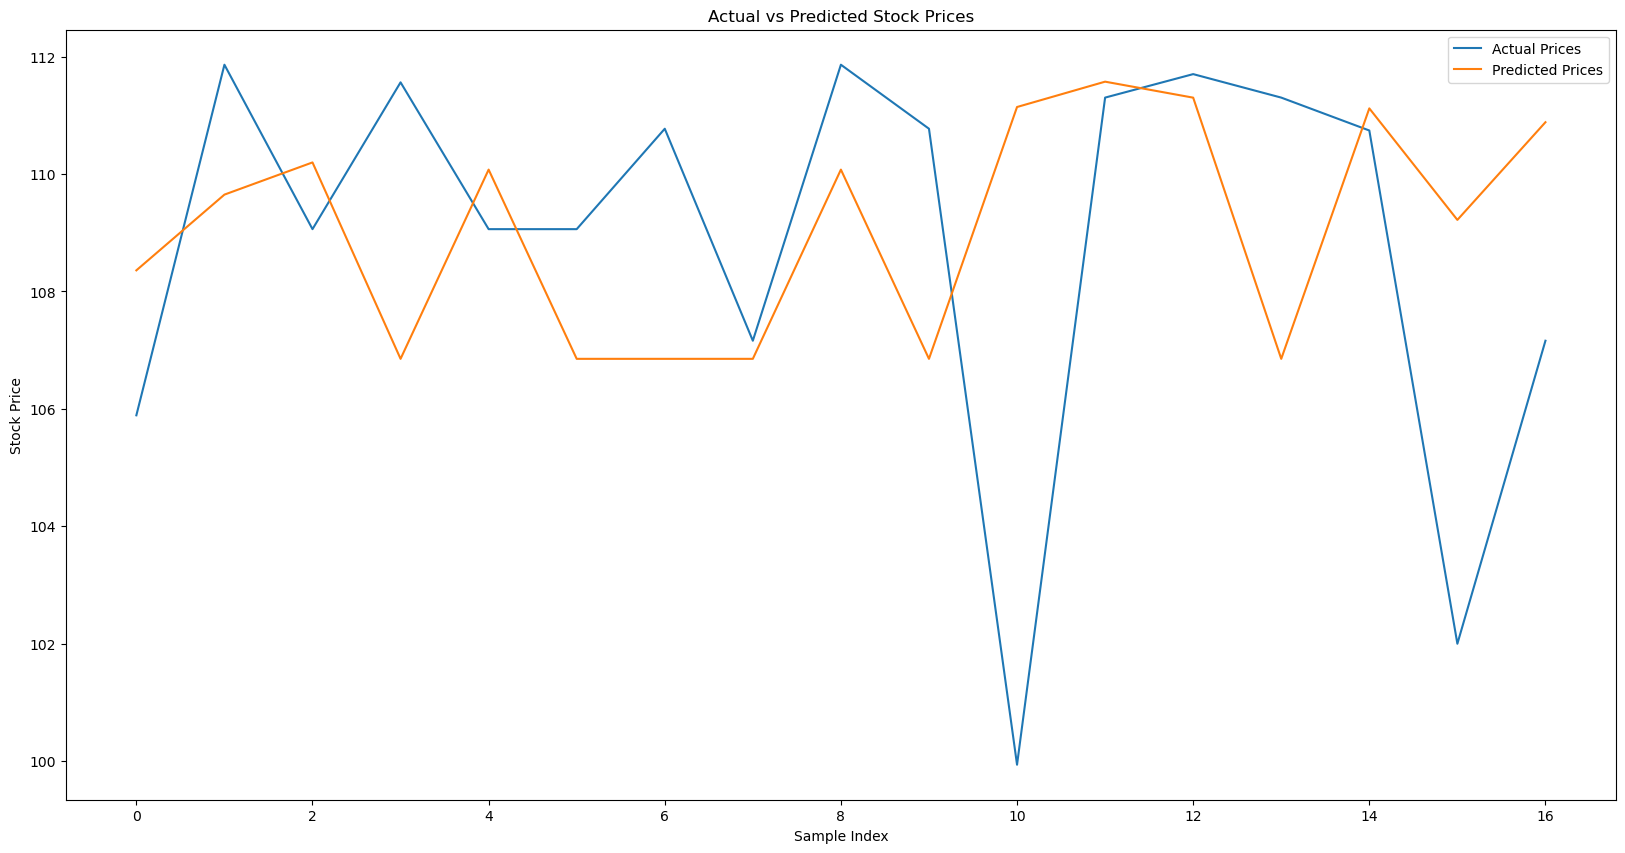

In [187]:
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for plotting
y_test_np = y_test.numpy()
predictions_np = predictions.numpy()

# Plot actual vs predicted stock prices
plt.figure(figsize=(20, 10))
plt.plot(y_test_np, label='Actual Prices')
plt.plot(predictions_np, label='Predicted Prices')
#plt.scatter(range(len(y_test_np)), y_test_np, label='Actual Prices', color='blue', s=20)
#plt.scatter(range(len(predictions_np)), predictions_np, label='Predicted Prices', color='red', s=20)
plt.legend()
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.show()
